In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:

# Load the image
image_path = 'data_archive/CelebA/test/005521.jpg'
image = Image.open(image_path)

# Resize the image to 256x256
resized_image = image.resize((256, 256))

# Display the image
plt.imshow(resized_image)
plt.axis('off')  # Hide the axis
plt.show()

In [1]:
from config import config

print("TRAIN_IMAGES Path:", config.TRAIN_IMAGES)


TRAIN_IMAGES Path: d:\Studystuff\Github\EdgeConnect_Plus_Inpainting_with_Edge_and_Color_Guidance\data_archive\CelebA\train


In [2]:
from config import config

print("TRAIN_IMAGES Path:", config.NUM_WORKERS)  # Should print a valid path
print("TEST_IMAGES Path:", config.TEST_IMAGES)
print("MASKS_PATH Path:", config.MASKS_PATH)


TRAIN_IMAGES Path: 4
TEST_IMAGES Path: d:\Studystuff\Github\EdgeConnect_Plus_Inpainting_with_Edge_and_Color_Guidance\data_archive\CelebA\test
MASKS_PATH Path: d:\Studystuff\Github\EdgeConnect_Plus_Inpainting_with_Edge_and_Color_Guidance\data_archive\Masks\train


In [ ]:
import torch
from config import config
from old_dataloader import get_dataloader_g1

# Initialize G1 DataLoader (Edge Generator Training)
train_loader_g1 = get_dataloader_g1(config.TRAIN_IMAGES, config.MASKS_PATH, config.BATCH_SIZE, config.NUM_WORKERS)
val_loader_g1 = get_dataloader_g1(config.VAL_IMAGES, config.MASKS_PATH, config.BATCH_SIZE, config.NUM_WORKERS)


print(f"✔ DataLoaders Initialized: G1-Train={len(train_loader_g1)}")



✔ DataLoaders Initialized: G1-Train=100
Train: 800
Val: 100


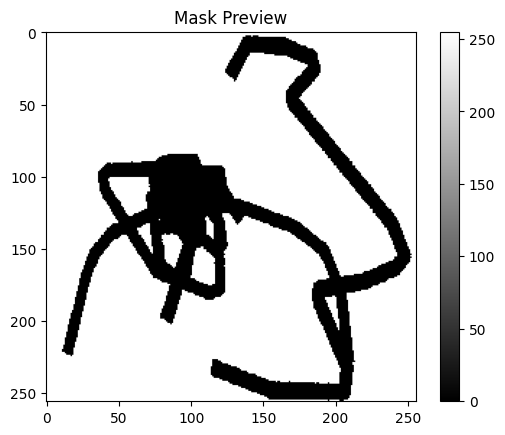

Unique values in mask: [  0 255]


In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the mask image correctly
mask_path = "data_archive/Masks/test/00001_test.png"  # Ensure correct path format
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale

# Check if the mask is loaded properly
if mask is None:
    raise FileNotFoundError(f"Mask not found at {mask_path}")
# mask = (mask > 127).astype(np.float32)  # Ensures mask is only 0 or 1
# mask = 1 - mask
# Display the mask
plt.imshow(mask, cmap="gray")
plt.title("Mask Preview")
plt.colorbar()
plt.show()
print("Unique values in mask:", np.unique(mask))


✔ DataLoaders Initialized: G1-Train=100

📊 G1 Dataloader (Edge Generator) Samples:
G1 Batch is a list with length: 4
  Item 0 (Masked Image) shape: torch.Size([8, 3, 256, 256])


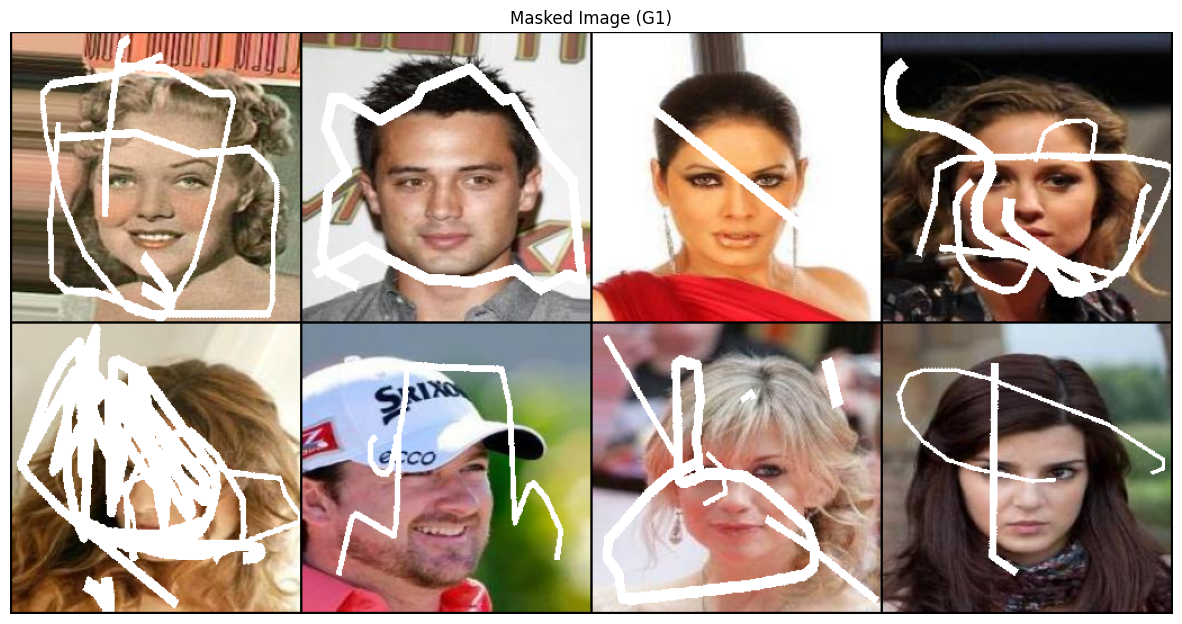

  Item 1 (Edges masked) shape: torch.Size([8, 1, 256, 256])


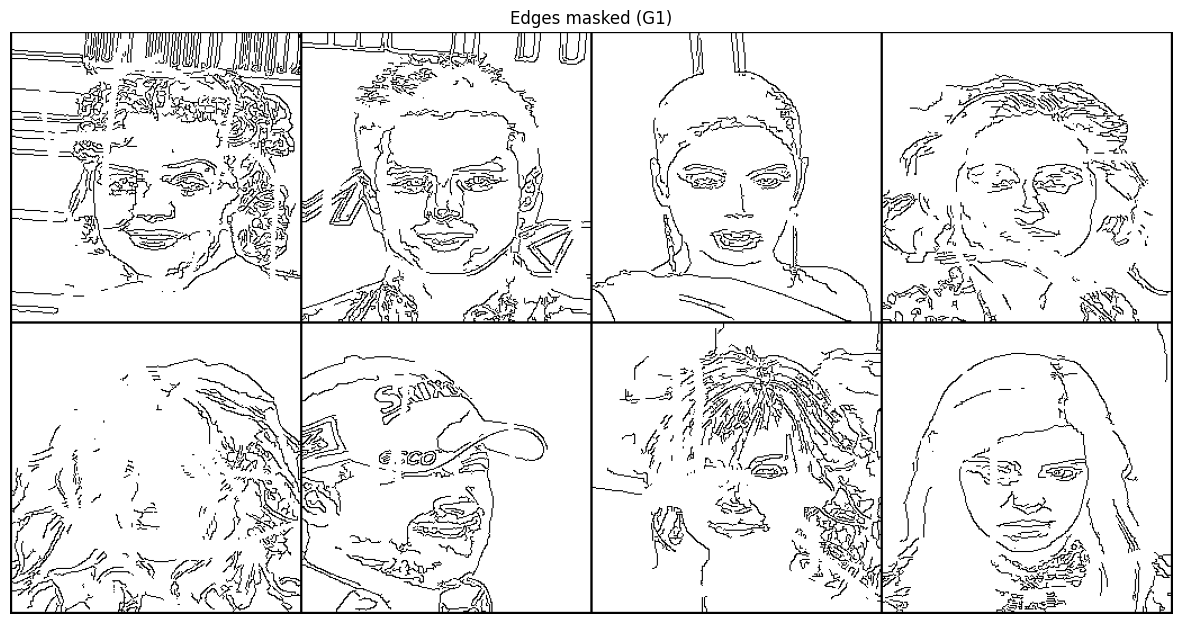

  Item 2 (Edges GT) shape: torch.Size([8, 1, 256, 256])


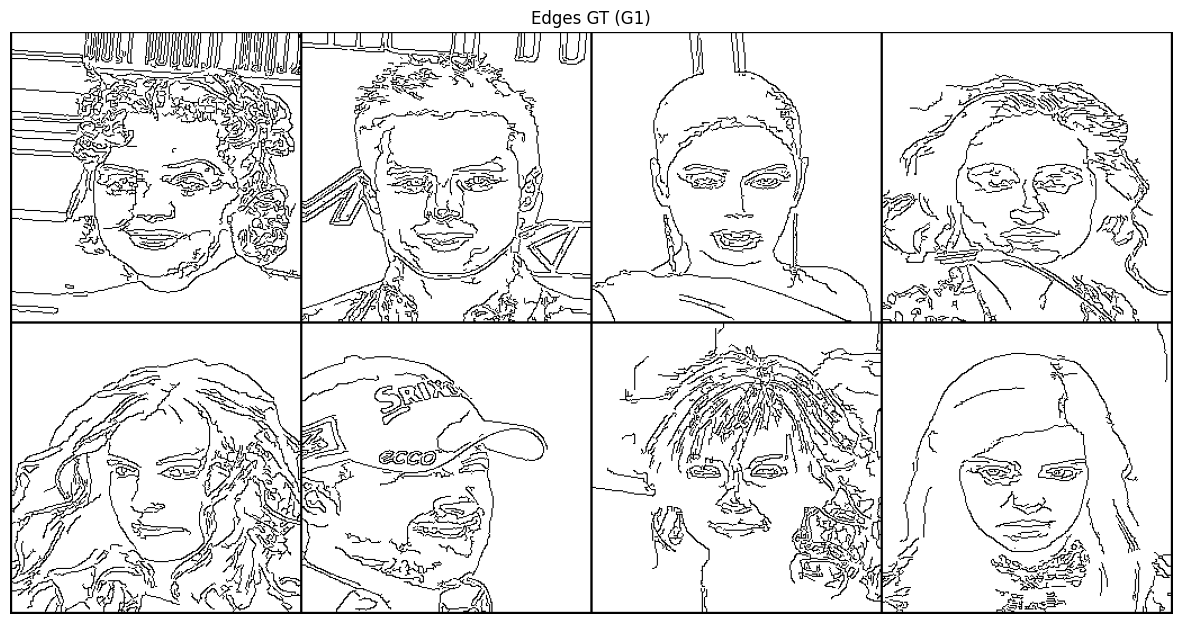

  Item 3 (Original Image) shape: torch.Size([8, 3, 256, 256])


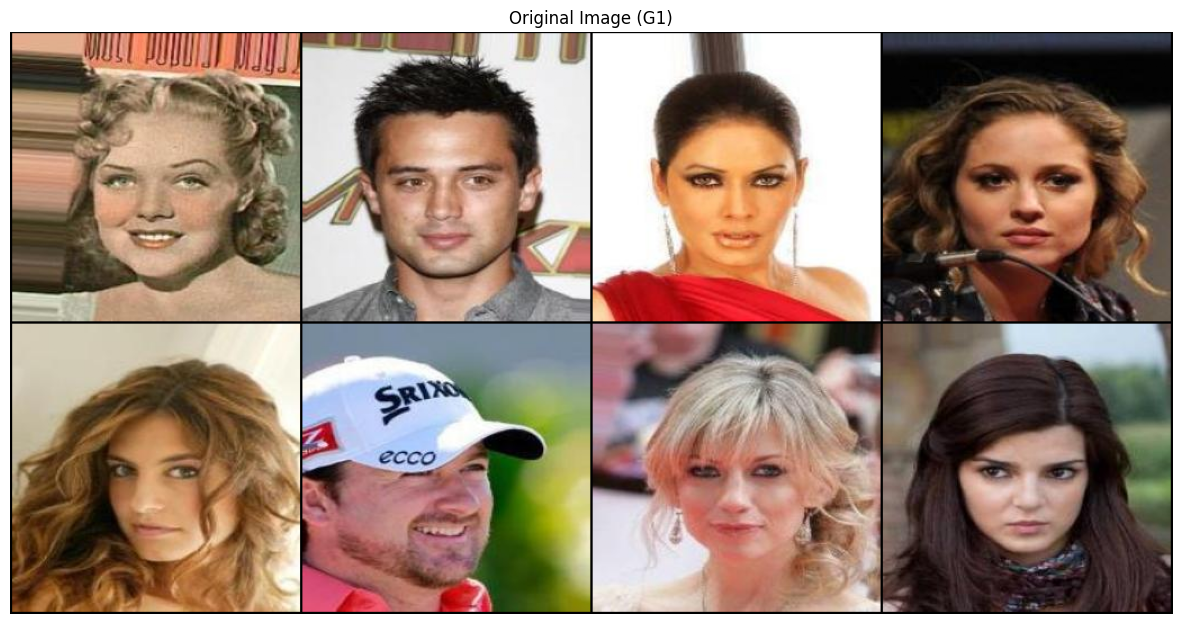

In [4]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch
from config import config
from old_dataloader import get_dataloader_g1

# Initialize G1 DataLoader (Edge Generator Training)
train_loader_g1 = get_dataloader_g1(config.TRAIN_IMAGES, config.MASKS_PATH, config.BATCH_SIZE, config.NUM_WORKERS)
val_loader_g1 = get_dataloader_g1(config.VAL_IMAGES, config.MASKS_PATH, config.BATCH_SIZE, config.NUM_WORKERS)

print(f"✔ DataLoaders Initialized: G1-Train={len(train_loader_g1)}")

# Function to display tensor images
def show_tensor_images(tensor, title=None, nrow=4):
    plt.figure(figsize=(15, 8))
    grid = vutils.make_grid(tensor.detach().cpu(), nrow=nrow, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Display G1 Dataloader samples
print("\n📊 G1 Dataloader (Edge Generator) Samples:")
batch_g1 = next(iter(train_loader_g1))

# Check the type of batch_g1
if isinstance(batch_g1, list):
    print("G1 Batch is a list with length:", len(batch_g1))
    
    # Assuming a standard order in the list: [images, edges, masks, grayscale]
    # Let's display each item if it looks like an image tensor
    labels = ["Masked Image", "Edges masked", "Edges GT", "Original Image"]
    
    for i, (item, label) in enumerate(zip(batch_g1, labels)):
        if isinstance(item, torch.Tensor):
            print(f"  Item {i} ({label}) shape: {item.shape}")
            
            # Make sure the tensor is in the right format for display
            if len(item.shape) == 4 and (item.shape[1] == 3 or item.shape[1] == 1):
                # For single-channel images, expand to 3 channels for better visualization
                if item.shape[1] == 1:
                    # Keep original for display
                    display_tensor = item
                else:
                    display_tensor = item
                    
                show_tensor_images(display_tensor, f"{label} (G1)")
            else:
                print(f"  Skipping display for item {i}: Unexpected shape {item.shape}")
        else:
            print(f"  Item {i} is not a tensor: {type(item)}")

elif isinstance(batch_g1, dict):
    print("G1 Batch is a dictionary with keys:", batch_g1.keys())
    
    # Display dictionary items as before
    for key, value in batch_g1.items():
        if isinstance(value, torch.Tensor):
            print(f"  {key}: {value.shape}")
            
    # Display some samples from G1 dataloader
    if 'images' in batch_g1:
        show_tensor_images(batch_g1['images'], "Original Images (G1)")
    if 'edges' in batch_g1:
        show_tensor_images(batch_g1['edges'], "Edge Maps (G1)")
    if 'masks' in batch_g1:
        show_tensor_images(batch_g1['masks'], "Masks (G1)")
    if 'grayscale' in batch_g1:
        show_tensor_images(batch_g1['grayscale'], "Grayscale Images (G1)")
else:
    print("G1 Batch is of type:", type(batch_g1))

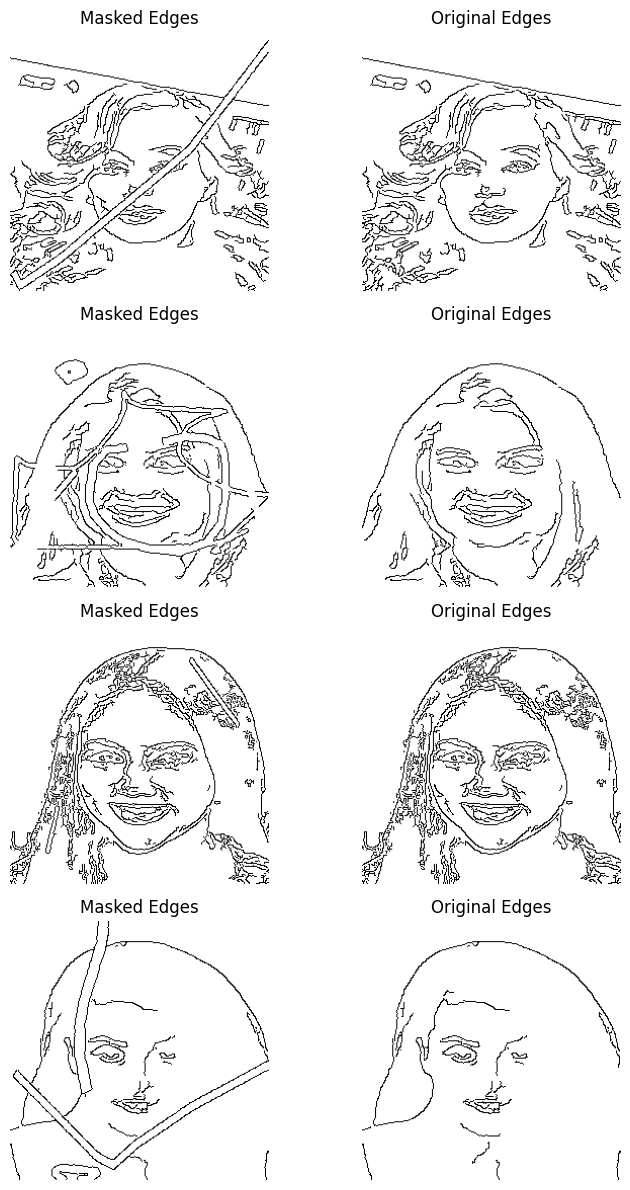

In [22]:
import torch
import matplotlib.pyplot as plt
from dataloader import get_dataloader_g1  # Import from your dataloader file

# Create dataloader
batch_size = 4  # Adjust batch size as needed
dataloader = get_dataloader_g1(config.TRAIN_IMAGES, config.MASKS_PATH, config.BATCH_SIZE, config.NUM_WORKERS)

# Function to visualize sample images
def visualize_samples(dataloader, num_samples=4):
    """Displays a few samples from the dataloader."""
    data_iter = iter(dataloader)
    edges_masked, edges_original  = next(data_iter)  # Fetch a batch

    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 3))

    for i in range(num_samples):
        # Convert tensors to numpy arrays
        edge_masked_np = edges_masked[i].squeeze(0).cpu().numpy()  # Remove channel dim
        edge_original_np = edges_original[i].squeeze(0).cpu().numpy()

        # Plot masked edges
        axes[i, 0].imshow(edge_masked_np, cmap="gray")
        axes[i, 0].set_title("Masked Edges")
        axes[i, 0].axis("off")

        # Plot original edges
        axes[i, 1].imshow(edge_original_np, cmap="gray")
        axes[i, 1].set_title("Original Edges")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


# Run the visualization
if __name__ == "__main__":
    visualize_samples(dataloader)


Visualizing with mask:


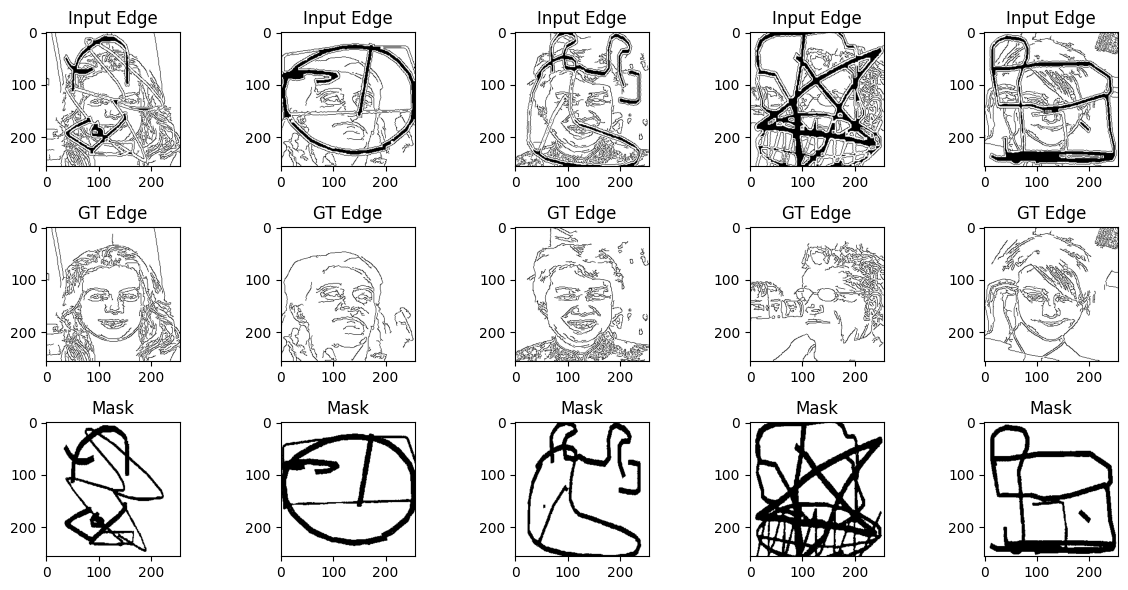

In [5]:
import matplotlib.pyplot as plt
from dataloader import get_dataloader_g1

# Load the dataloader without mask
dataloader_no_mask = get_dataloader_g1(split="val", use_mask=False)
batch_no_mask = next(iter(dataloader_no_mask))

# Load the dataloader with mask
dataloader_with_mask = get_dataloader_g1(split="train", use_mask=True)
batch_with_mask = next(iter(dataloader_with_mask))

def visualize_edges(batch, use_mask=False):
    """Visualize input edges, ground truth edges, and mask (if used)."""
    fig, axes = plt.subplots(3 if use_mask else 2, 5, figsize=(12, 6))

    for i in range(5):  # Show 5 samples
        input_edge = batch["input_edge"][i].squeeze(0).cpu().numpy()
        gt_edge = batch["gt_edge"][i].squeeze(0).cpu().numpy()

        axes[0, i].imshow(input_edge, cmap="gray")
        axes[0, i].set_title("Input Edge")

        axes[1, i].imshow(gt_edge, cmap="gray")
        axes[1, i].set_title("GT Edge")

        if use_mask:
            mask = batch["mask"][i].squeeze(0).cpu().numpy()
            axes[2, i].imshow(mask, cmap="gray")
            axes[2, i].set_title("Mask")

    plt.tight_layout()
    plt.show()

# # Visualize without mask
# print("Visualizing without mask:")
# visualize_edges(batch_no_mask, use_mask=False)

# Visualize with mask
print("Visualizing with mask:")
visualize_edges(batch_with_mask, use_mask=True)
